In [2]:
import torch
import random
import math
import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt

from IPython import display

%matplotlib inline  


# Pathfinder

Given a set of 2D points, for example the (x,y) coordiantes of characters on an image, and  astarting direction defined by two points, the algorithm will visit all points following a 'natural' trajectory. By natural, I mean a trajectory that human eyes might follow when reading text. To do this,the algorithm siply calculates a cost function for every possible move that penalizes making changes to the current direction and ives preferences to points that are closer to the current position.


In [68]:
# Generate random points to test the algorithm

# total number of points
num_points = 100

# radii  
radii = [100,120,130]

max_angle = 3.14*2#/2.  

def make_point(i):
    # select random radius from list of radii
    radius = random.choice(radii)
    
    # generate random point along the selected radius
    alpha = random.random() * max_angle
    
    x = math.sin(alpha) * radius 
    y = math.cos(alpha) * radius 
    return [x, y, radius, False, i]

def make_point_rnd(i):

    x = random.random() * 100    
    y = random.random() * 100    
    r = random.randint(0,2) 
    return [x, y, radii[r], False,i]

def make_point_spiral(i):
    # select random radius from list of radii
    radius = random.choice(radii)-100
    
    # generate random point along the selected radius
    alpha = 3 * 2 * 3.14 * i /140
    
    x = math.sin(alpha) * (10+radius+i)
    y = math.cos(alpha) * (10+radius+i) 
    return [x, y, radius, False, i]


P = [ make_point(i) for i in range(num_points)]

P = torch.tensor(P)

#radii = [0]
#P = torch.tensor([[1,1,0,False,0], [2,2,0,False,1], [3,3,0,False,2], [4,4,0,False,3], [3.3,3,0,False,4] ])

X = P[:, 0]
Y = P[:, 1]
R = P[:, 2]
V = P[:, 3] # visited




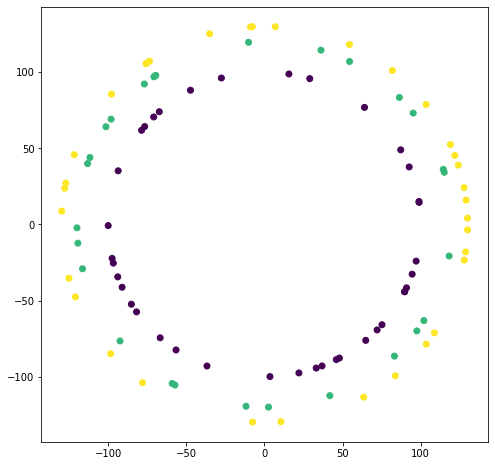

In [69]:
colors = R
fig = plt.figure(figsize=(8,8))
plt.scatter(X.numpy(), Y.numpy(), c=colors)

In [57]:
class Pathfinder():
    def __init__(self, points):
        self.points = points
        # points = tensor ([N, 3])  
        #    N=number of points 
        #          0: X coordinate
        #          1: Y Coordinate 
        #          2: radius (for evaluation purposes - this value won't be known on real data )
        return
    
       
    
    def next(self, start, direction=[-1, +1]):
        
        p_previous = start[0][0:2]
        p0 = start[1][0:2] 
        
        
        points = self.points[self.points[:,3] == 0] # consider only unvisited points
        
        if len(points) > 0:
        
            # for each point in self.points compute similarity to  vector(p_previous->p0)
            input1 = points[:,0:2] - p0
            input2 = p0[0:2].expand((input1.shape[0], -1)) - p_previous
            cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
            
            directions_offsets = cos(input1, input2) 

            # for each point is self.point compute euclidean distance to p0 (current point)
            distance = torch.sqrt((points[:,0] - p0[0])**2 + (points[:,1] - p0[1])**2)

            # compute cost 
            cost = -1. * directions_offsets +  0.1*((0+distance / distance.max())) #.log()

            #print("DISTANCE", distance.max())

            # sort by min cost ascending
            cost_sorted = torch.argsort(input=cost, dim=0, descending=False)
            debug1 = torch.cat((points, directions_offsets.unsqueeze(1), cost.unsqueeze(1)), dim=1)

            #print("CUR DIR", current_direction)
            #print("COST\n", (debug1[cost_sorted])[0:5] )

            i_next = cost_sorted[0]
            
            # mark as visited
            self.points[int(points[i_next,4]), 3] = True
            #print ("NEXT", self.points[int(points[i_next,4])], points[i_next])
            
            next_point = points[i_next]

            #cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
            #new_direction = cos(p0[0:2], next_point[0:2])
            #print("directions", current_direction, new_direction.item())
            
            return (p0, next_point)
        else:
            return None
    
pf = Pathfinder(P)    


In [55]:

def find_start(points):
    #returns the index of two points from where we will start
    # you have to replace this method with your custom logic *****

    r = random.choice(radii)
    points = points[points[:,2] == r]
    sorted_points = torch.argsort(points[:,1]**2 + points[:,1]**2, dim=0, descending=False)
    
    p0 = points[sorted_points[0]]
    p1 = points[sorted_points[1]]
    P[:,3] = False
    P[sorted_points[0],3] = True
    P[sorted_points[1],3] = True
    return (p0, p1)




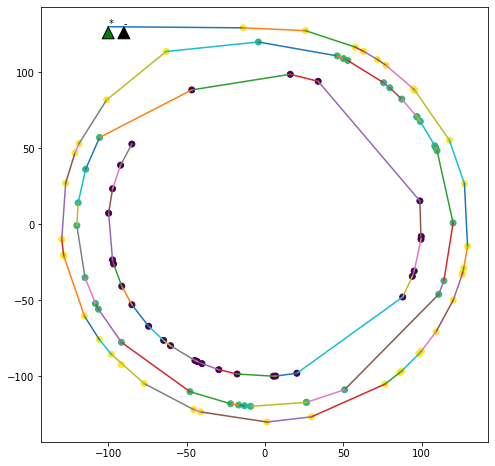

In [67]:



colors = R

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(X.numpy(), Y.numpy(), c=colors)

start_point = find_start(P)
print("START", start_point)

start_point = (torch.tensor([-100,130]),torch.tensor([-90,130]))


p0 = start_point[0]
next_point = pf.next(start_point)

ax.annotate("*", (p0[0], p0[1]), arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate("-", (next_point[0][0], next_point[0][1]), arrowprops=dict(facecolor='black', shrink=0.05))

annotate = False
i=0
while next_point is not None:
    p1 = next_point[1]
    ax.plot([p0[0], p1[0]], [p0[1],p1[1]])
    if (annotate):
        ax.annotate(str(i), (p0[0], p0[1]))
    next_point = pf.next(next_point)
    #plt.pause(0.05)
    if next_point is None:
        break

    p0 = p1
    i+=1
    #print(next_point)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(2./len(P))
    
    #if i>10:
    #    break
    
display.clear_output(wait=True)    

